In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format
sns.set_theme(color_codes=True)

In [2]:
df = pd.read_csv('./data/stack-overflow-developer-survey-2021/survey_results_public.csv')

In [3]:
def log(f):
    def wrapper(df, *args, **kwargs):
        start = dt.datetime.now()
        result = f(df, *args, **kwargs)
        stop = dt.datetime.now()
        print(f'{f.__name__}:\n  runtime={stop - start}, end shape={result.shape}')
        return result
    return wrapper

@log
def startPipeline(df):
    return df.copy()

@log
def clean(df):
    df = df[[
        'ConvertedCompYearly',
        # 'EdLevel', # will need to vectorize (worst = 0, best = 1, rest in between)
        'Employment',
        # 'Age1stCode', 
        'YearsCode', 
        'YearsCodePro', 
        # 'OrgSize'
    ]]
    df = df[df["Employment"] == "Employed full-time"]
    df = df.drop("Employment", axis=1)
    df = df.dropna(subset=['ConvertedCompYearly'])
    # do this better. don't drop these. vectorize them.
    # drop rows in 'YearsCode', 'YearsCodePro' that are 'Less than 1 year'
    df = df[df['YearsCode'].str.contains('Less than 1 year')==False]
    df = df[df['YearsCodePro'].str.contains('Less than 1 year')==False]
    df = df[df['YearsCode'].str.contains('More than 50 years')==False]
    df = df[df['YearsCodePro'].str.contains('More than 50 years')==False]
    df = df.round(2)

    return df

@log 
def removeOutliers(df):
    # df = df[(np.abs(stats.zscore(df['ConvertedCompYearly'])) < .25)]
    df = df[df["ConvertedCompYearly"] <= 300000]
    df = df[df["ConvertedCompYearly"] >= 15000]
    return df

df_processed = (df
 .pipe(startPipeline)
 .pipe(clean)
 .pipe(removeOutliers)
)

startPipeline:
  runtime=0:00:00.028031, end shape=(83439, 48)
clean:
  runtime=0:00:00.122992, end shape=(38506, 3)
removeOutliers:
  runtime=0:00:00.003001, end shape=(32440, 3)


In [4]:
df_processed.head()

,ConvertedCompYearly,YearsCode,YearsCodePro
9,51552.00,7,4
11,46482.00,12,5
12,77290.00,15,6
16,17748.00,6,2
17,46135.00,9,6


In [5]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32440 entries, 9 to 83438
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ConvertedCompYearly  32440 non-null  float64
 1   YearsCode            32440 non-null  object 
 2   YearsCodePro         32440 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1013.8+ KB


In [6]:
df['Country'].value_counts()

United States of America                                15288
India                                                   10511
Germany                                                  5625
United Kingdom of Great Britain and Northern Ireland     4475
Canada                                                   3012
                                                        ...  
Saint Kitts and Nevis                                       1
Dominica                                                    1
Saint Vincent and the Grenadines                            1
Tuvalu                                                      1
Papua New Guinea                                            1
Name: Country, Length: 181, dtype: int64

In [7]:
df_processed.describe()

,ConvertedCompYearly
count,32440.00
mean,77436.57
std,51585.35
min,15000.00
25%,39324.00
50%,64859.00
75%,100524.00
max,300000.00


In [8]:
reg = LinearRegression()
label = 'ConvertedCompYearly'
labels = df_processed[label]
train = df_processed.drop([label], axis=1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state=1776)

In [10]:
reg.fit(x_train, y_train)

LinearRegression()

In [11]:
def performance(x, y, name):
    y_predict = reg.predict(x)
    rmse = (np.sqrt(mean_squared_error(y, y_predict)))
    r2 = r2_score(y, y_predict)

    print(name)
    print(f'  rmse={rmse}, r2={r2}')


performance(x_train, y_train, 'train')
performance(x_test, y_test, 'test')

train
  rmse=48735.876129219636, r2=0.10863140583697295
test
  rmse=48580.469851001566, r2=0.10806863469144679


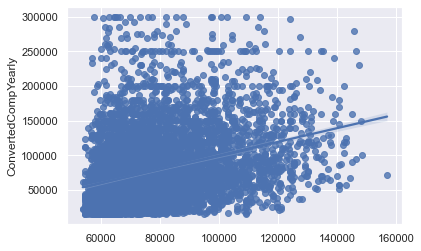

In [12]:
predicted = reg.predict(x_test)
expected = y_test
ax = sns.regplot(x=predicted, y=expected)